# **1. DS Part**

## **1.1 Loading the data**

- It is a good practise to import everything at the same place.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from html import unescape
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

In [6]:
#Read the .csv file
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

In [7]:
display(train_df)

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative
...,...,...
39995,It's the 1920s. And a man named Walt Disney wa...,positive
39996,"The first (and only) time I saw ""Shades"" was d...",negative
39997,This was such a waste of time. Danger: If you ...,negative
39998,this is by far the most pathetic movie Indian ...,negative


## **1.2 Analyse the data**

In [8]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB
None


- We have two features. The review of the films, and the sentiment whether the review is positive or negative.

- Next, we will figure out, if the data set is balanced or not.

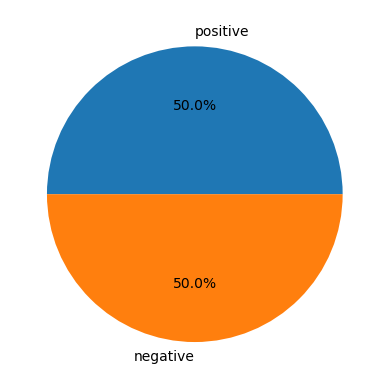

In [9]:
plt.pie(train_df['sentiment'].value_counts(), labels=train_df['sentiment'].unique().tolist(), autopct='%1.1f%%')
plt.show()

- The data set is balanced.

- Next, I need to encode the sentiment feature.

In [10]:
def sentiment(sentiment):
    if sentiment == 'negative':     #'negative' -> 0
        return 0
    if sentiment == 'positive':     #'positive' -> 1
        return 1

In [11]:
#Apply the encoding.
train_df['sentiment'] = train_df['sentiment'].apply(sentiment)
test_df['sentiment'] = test_df['sentiment'].apply(sentiment)

In [13]:
def count_words(text):
    words = text.split()
    return len(words)

In [14]:
train_df['count'] = train_df['review'].apply(count_words)

In [15]:
total_words = train_df['count'].sum()
print(total_words)

9254510


In [20]:
train_df[train_df['count']>100]

,review,sentiment,count
0,I caught this little gem totally by accident b...,1,161
1,I can't believe that I let myself into this mo...,0,170
3,If there's one thing I've learnt from watching...,0,314
4,"I remember when this was in theaters, reviews ...",0,183
5,Opera (the U.S. title is terror at the opera) ...,1,211
...,...,...,...
39995,It's the 1920s. And a man named Walt Disney wa...,1,178
39996,"The first (and only) time I saw ""Shades"" was d...",0,198
39997,This was such a waste of time. Danger: If you ...,0,137
39998,this is by far the most pathetic movie Indian ...,0,144


- Next, we can check how many words a review contains average.

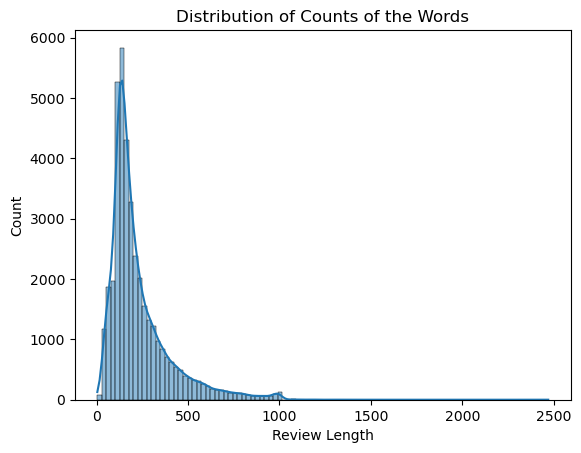

In [21]:
sns.histplot(train_df['count'], bins=100, kde=True)
plt.title('Distribution of Counts of the Words')
plt.xlabel('Review Length')
plt.show()

- Average around 200 words.
- Next, we will see the distribution of the review lengths in letters.

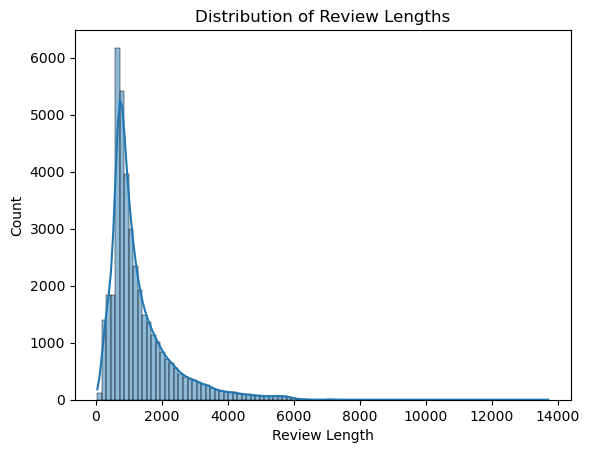

In [12]:
sns.histplot(train_df['review'].apply(len), bins=100, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.show()

- Average arund 800-900 letters in a review.

In [9]:
# A function that creates wordcloud whether the reviews are postive or negative.
def wordcloud(binary: int, text: str):
    reviews = ' '.join(train_df[train_df['sentiment'] == binary]['review'])
    wordcloud = WordCloud(width=800, height=400, random_state=42).generate(reviews)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(text)
    plt.show()

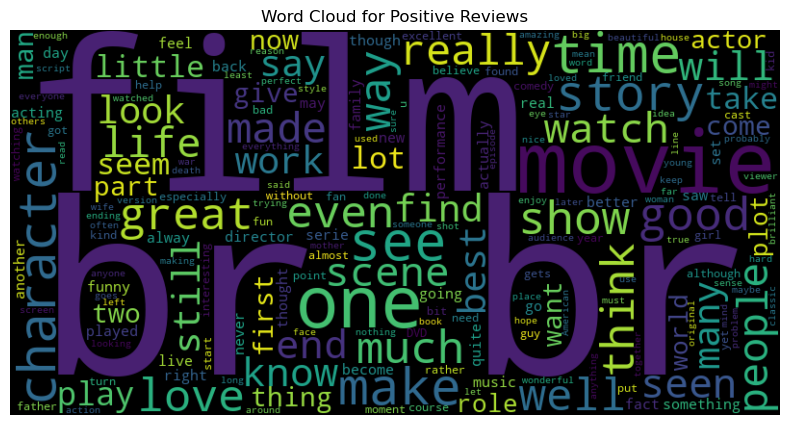

In [10]:
wordcloud(1, 'Word Cloud for Positive Reviews')

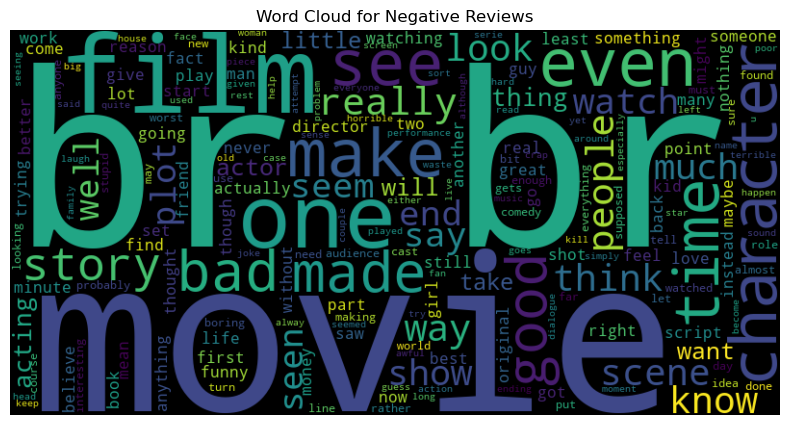

In [11]:
wordcloud(0, 'Word Cloud for Negative Reviews')

- The most common words in the reviews. But, what is the 'br' twice. Maybe HTML tag.

# **1.3 Text Preprocessing**

### **1.3.1 Analyse one record**

In this section, I will go with a random review, and apply basic preprocessing techniques to be better to modeling later.

In [12]:
example_review=train_df['review'][10]
print(example_review)

Between 1937 and 1939, Twentieth Century-Fox made a ton of Mr. Moto films. However, towards the end of the series, it was obvious that the studio had "jumped the shark", so to speak. This phrase indicates that a TV show has passed its prime and the executives in charge decided to invigorate the show by fundamentally changing the formula. For example, with "The Brady Bunch" they introduced the annoying 'Cousin Oliver' and with "Family Ties" they introduced a freak baby who grew up six years in only one season! With the Moto films, they'd jumped the shark by introducing comic relief because they thought that these intelligent films needed to be re-tooled. In the previous film, Warren Hymer played an annoying wrestler. And, in this film the character Archibald Featherstone appears. Featherstone might just be one of the most annoying examples of comic relief ever, as you kept hoping someone (preferably Moto) would kill him just to shut him up!! Although he's supposed to work for the famed 

It contains HTML tags, I need to remove them.

I will use the following function to deal with them.

In [13]:
def clean_html_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    cleaned_text = soup.get_text(separator=' ', strip=True)
    cleaned_text = unescape(cleaned_text)
    return cleaned_text

In [14]:
example_review = clean_html_tags(example_review)
print(example_review)

Between 1937 and 1939, Twentieth Century-Fox made a ton of Mr. Moto films. However, towards the end of the series, it was obvious that the studio had "jumped the shark", so to speak. This phrase indicates that a TV show has passed its prime and the executives in charge decided to invigorate the show by fundamentally changing the formula. For example, with "The Brady Bunch" they introduced the annoying 'Cousin Oliver' and with "Family Ties" they introduced a freak baby who grew up six years in only one season! With the Moto films, they'd jumped the shark by introducing comic relief because they thought that these intelligent films needed to be re-tooled. In the previous film, Warren Hymer played an annoying wrestler. And, in this film the character Archibald Featherstone appears. Featherstone might just be one of the most annoying examples of comic relief ever, as you kept hoping someone (preferably Moto) would kill him just to shut him up!! Although he's supposed to work for the famed 

There are numbers, and punctuations that I need to remove, without these our model will predict better.

In [15]:
example_review = re.sub('[^a-zA-Z]',' ', example_review)
print(example_review)

Between      and       Twentieth Century Fox made a ton of Mr  Moto films  However  towards the end of the series  it was obvious that the studio had  jumped the shark   so to speak  This phrase indicates that a TV show has passed its prime and the executives in charge decided to invigorate the show by fundamentally changing the formula  For example  with  The Brady Bunch  they introduced the annoying  Cousin Oliver  and with  Family Ties  they introduced a freak baby who grew up six years in only one season  With the Moto films  they d jumped the shark by introducing comic relief because they thought that these intelligent films needed to be re tooled  In the previous film  Warren Hymer played an annoying wrestler  And  in this film the character Archibald Featherstone appears  Featherstone might just be one of the most annoying examples of comic relief ever  as you kept hoping someone  preferably Moto  would kill him just to shut him up   Although he s supposed to work for the famed 

All the words need to be lowercase to tokenize them later.

In [16]:
example_review = str(example_review).lower()
print(example_review)

between      and       twentieth century fox made a ton of mr  moto films  however  towards the end of the series  it was obvious that the studio had  jumped the shark   so to speak  this phrase indicates that a tv show has passed its prime and the executives in charge decided to invigorate the show by fundamentally changing the formula  for example  with  the brady bunch  they introduced the annoying  cousin oliver  and with  family ties  they introduced a freak baby who grew up six years in only one season  with the moto films  they d jumped the shark by introducing comic relief because they thought that these intelligent films needed to be re tooled  in the previous film  warren hymer played an annoying wrestler  and  in this film the character archibald featherstone appears  featherstone might just be one of the most annoying examples of comic relief ever  as you kept hoping someone  preferably moto  would kill him just to shut him up   although he s supposed to work for the famed 

In [17]:
tokenized_example_review = word_tokenize(example_review)
print(tokenized_example_review)

['between', 'and', 'twentieth', 'century', 'fox', 'made', 'a', 'ton', 'of', 'mr', 'moto', 'films', 'however', 'towards', 'the', 'end', 'of', 'the', 'series', 'it', 'was', 'obvious', 'that', 'the', 'studio', 'had', 'jumped', 'the', 'shark', 'so', 'to', 'speak', 'this', 'phrase', 'indicates', 'that', 'a', 'tv', 'show', 'has', 'passed', 'its', 'prime', 'and', 'the', 'executives', 'in', 'charge', 'decided', 'to', 'invigorate', 'the', 'show', 'by', 'fundamentally', 'changing', 'the', 'formula', 'for', 'example', 'with', 'the', 'brady', 'bunch', 'they', 'introduced', 'the', 'annoying', 'cousin', 'oliver', 'and', 'with', 'family', 'ties', 'they', 'introduced', 'a', 'freak', 'baby', 'who', 'grew', 'up', 'six', 'years', 'in', 'only', 'one', 'season', 'with', 'the', 'moto', 'films', 'they', 'd', 'jumped', 'the', 'shark', 'by', 'introducing', 'comic', 'relief', 'because', 'they', 'thought', 'that', 'these', 'intelligent', 'films', 'needed', 'to', 'be', 're', 'tooled', 'in', 'the', 'previous', 'fi

In [18]:
stop_words = set(stopwords.words('english'))

tokenized_example_review = [item for item in tokenized_example_review if item not in stop_words]
print(tokenized_example_review)

['twentieth', 'century', 'fox', 'made', 'ton', 'mr', 'moto', 'films', 'however', 'towards', 'end', 'series', 'obvious', 'studio', 'jumped', 'shark', 'speak', 'phrase', 'indicates', 'tv', 'show', 'passed', 'prime', 'executives', 'charge', 'decided', 'invigorate', 'show', 'fundamentally', 'changing', 'formula', 'example', 'brady', 'bunch', 'introduced', 'annoying', 'cousin', 'oliver', 'family', 'ties', 'introduced', 'freak', 'baby', 'grew', 'six', 'years', 'one', 'season', 'moto', 'films', 'jumped', 'shark', 'introducing', 'comic', 'relief', 'thought', 'intelligent', 'films', 'needed', 'tooled', 'previous', 'film', 'warren', 'hymer', 'played', 'annoying', 'wrestler', 'film', 'character', 'archibald', 'featherstone', 'appears', 'featherstone', 'might', 'one', 'annoying', 'examples', 'comic', 'relief', 'ever', 'kept', 'hoping', 'someone', 'preferably', 'moto', 'would', 'kill', 'shut', 'although', 'supposed', 'work', 'famed', 'scotland', 'yard', 'shows', 'intelligence', 'acumen', 'brain', '

In [19]:
stemmer = PorterStemmer()
tokenized_stemmer_example_review = [stemmer.stem(word) for word in tokenized_example_review]
print("Stemmed Words:", tokenized_stemmer_example_review)

Stemmed Words: ['twentieth', 'centuri', 'fox', 'made', 'ton', 'mr', 'moto', 'film', 'howev', 'toward', 'end', 'seri', 'obviou', 'studio', 'jump', 'shark', 'speak', 'phrase', 'indic', 'tv', 'show', 'pass', 'prime', 'execut', 'charg', 'decid', 'invigor', 'show', 'fundament', 'chang', 'formula', 'exampl', 'bradi', 'bunch', 'introduc', 'annoy', 'cousin', 'oliv', 'famili', 'tie', 'introduc', 'freak', 'babi', 'grew', 'six', 'year', 'one', 'season', 'moto', 'film', 'jump', 'shark', 'introduc', 'comic', 'relief', 'thought', 'intellig', 'film', 'need', 'tool', 'previou', 'film', 'warren', 'hymer', 'play', 'annoy', 'wrestler', 'film', 'charact', 'archibald', 'featherston', 'appear', 'featherston', 'might', 'one', 'annoy', 'exampl', 'comic', 'relief', 'ever', 'kept', 'hope', 'someon', 'prefer', 'moto', 'would', 'kill', 'shut', 'although', 'suppos', 'work', 'fame', 'scotland', 'yard', 'show', 'intellig', 'acumen', 'brain', 'damag', 'turnip', 'scene', 'boorish', 'unnecessari', 'peter', 'lorr', 'loo

In [20]:
lemmatizer = WordNetLemmatizer()
tokenized_lemmatizer_example_review = [lemmatizer.lemmatize(word) for word in tokenized_example_review]
print("Lemmatized Words:", tokenized_lemmatizer_example_review)

Lemmatized Words: ['twentieth', 'century', 'fox', 'made', 'ton', 'mr', 'moto', 'film', 'however', 'towards', 'end', 'series', 'obvious', 'studio', 'jumped', 'shark', 'speak', 'phrase', 'indicates', 'tv', 'show', 'passed', 'prime', 'executive', 'charge', 'decided', 'invigorate', 'show', 'fundamentally', 'changing', 'formula', 'example', 'brady', 'bunch', 'introduced', 'annoying', 'cousin', 'oliver', 'family', 'tie', 'introduced', 'freak', 'baby', 'grew', 'six', 'year', 'one', 'season', 'moto', 'film', 'jumped', 'shark', 'introducing', 'comic', 'relief', 'thought', 'intelligent', 'film', 'needed', 'tooled', 'previous', 'film', 'warren', 'hymer', 'played', 'annoying', 'wrestler', 'film', 'character', 'archibald', 'featherstone', 'appears', 'featherstone', 'might', 'one', 'annoying', 'example', 'comic', 'relief', 'ever', 'kept', 'hoping', 'someone', 'preferably', 'moto', 'would', 'kill', 'shut', 'although', 'supposed', 'work', 'famed', 'scotland', 'yard', 'show', 'intelligence', 'acumen', 

In [21]:
tokenized_lemmatizer_example_review = [i for i in tokenized_lemmatizer_example_review if len(i) > 2]
tokenized_stemmer_example_review = [i for i in tokenized_stemmer_example_review if len(i) > 2]

print("Lemmatized Words:", tokenized_lemmatizer_example_review)
print("Stemmed Words:", tokenized_stemmer_example_review)

Lemmatized Words: ['twentieth', 'century', 'fox', 'made', 'ton', 'moto', 'film', 'however', 'towards', 'end', 'series', 'obvious', 'studio', 'jumped', 'shark', 'speak', 'phrase', 'indicates', 'show', 'passed', 'prime', 'executive', 'charge', 'decided', 'invigorate', 'show', 'fundamentally', 'changing', 'formula', 'example', 'brady', 'bunch', 'introduced', 'annoying', 'cousin', 'oliver', 'family', 'tie', 'introduced', 'freak', 'baby', 'grew', 'six', 'year', 'one', 'season', 'moto', 'film', 'jumped', 'shark', 'introducing', 'comic', 'relief', 'thought', 'intelligent', 'film', 'needed', 'tooled', 'previous', 'film', 'warren', 'hymer', 'played', 'annoying', 'wrestler', 'film', 'character', 'archibald', 'featherstone', 'appears', 'featherstone', 'might', 'one', 'annoying', 'example', 'comic', 'relief', 'ever', 'kept', 'hoping', 'someone', 'preferably', 'moto', 'would', 'kill', 'shut', 'although', 'supposed', 'work', 'famed', 'scotland', 'yard', 'show', 'intelligence', 'acumen', 'brain', 'da

In [22]:
lemmatizer_review = ' '.join(tokenized_lemmatizer_example_review)
stemmer_review = ' '.join(tokenized_stemmer_example_review)

print("Lemmatized Review:", lemmatizer_review)
print("Stemmed Review:", stemmer_review)

Lemmatized Review: twentieth century fox made ton moto film however towards end series obvious studio jumped shark speak phrase indicates show passed prime executive charge decided invigorate show fundamentally changing formula example brady bunch introduced annoying cousin oliver family tie introduced freak baby grew six year one season moto film jumped shark introducing comic relief thought intelligent film needed tooled previous film warren hymer played annoying wrestler film character archibald featherstone appears featherstone might one annoying example comic relief ever kept hoping someone preferably moto would kill shut although supposed work famed scotland yard show intelligence acumen brain damaged turnip scene boorish unnecessary peter lorre look pained stand watch buffoon act bad truly destroys could one better moto film due clever plot plot crown queen sheba discovered opening scene moto international policeman amoral character originally hand protect precious item stolen g

### **1.3.2 Build preprocessing pipeline**

I will build pipelines (comparing stemming and lemmatizing) with these preprocessing steps, that will be applied to each review.

In [23]:
def lemmatized_preprocess_text(text):
    text = clean_html_tags(text)
    text = re.sub('[^a-zA-Z]',' ', text)
    text = str(text).lower()
    tokenized = word_tokenize(text)
    tokenized = [item for item in tokenized if item not in stop_words]
    tokenized = [lemmatizer.lemmatize(word=w, pos='v') for w in tokenized]
    tokenized = [i for i in tokenized if len(i) > 2]
    text = ' '.join(tokenized)
    return text

In [24]:
def stemmed_preprocess_text(text):
    text = clean_html_tags(text)
    text = re.sub('[^a-zA-Z]',' ', text)
    text = str(text).lower()
    tokenized = word_tokenize(text)
    tokenized = [item for item in tokenized if item not in stop_words]
    tokenized = [stemmer.stem(word) for word in tokenized]
    tokenized = [i for i in tokenized if len(i) > 2]
    text = ' '.join(tokenized)
    return text

- Preprocessing datas with the stemming/lemmatizing preprocessing method.

In [25]:
train_df['lemmatized_preprocessed_review']=train_df['review'].apply(lemmatized_preprocess_text)

C:\Users\jenei\AppData\Local\Temp\ipykernel_6268\2548397863.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_text, 'html.parser')


In [26]:
train_df['stemmed_preprocessed_review']=train_df['review'].apply(stemmed_preprocess_text)

C:\Users\jenei\AppData\Local\Temp\ipykernel_6268\2548397863.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_text, 'html.parser')


In [27]:
test_df['lemmatized_preprocessed_review']=test_df['review'].apply(lemmatized_preprocess_text)

C:\Users\jenei\AppData\Local\Temp\ipykernel_6268\2548397863.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_text, 'html.parser')


In [28]:
test_df['stemmed_preprocessed_review']=test_df['review'].apply(stemmed_preprocess_text)

C:\Users\jenei\AppData\Local\Temp\ipykernel_6268\2548397863.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_text, 'html.parser')


### **1.3.3 Splitting Data**

In [29]:
train_df

,review,sentiment,lemmatized_preprocessed_review,stemmed_preprocessed_review
0,I caught this little gem totally by accident b...,1,catch little gem totally accident back revival...,caught littl gem total accid back reviv theatr...
1,I can't believe that I let myself into this mo...,0,believe let movie accomplish favor friends ask...,believ let movi accomplish favor friend ask ea...
2,*spoiler alert!* it just gets to me the nerve ...,0,spoiler alert get nerve people remake use term...,spoiler alert get nerv peopl remak use term lo...
3,If there's one thing I've learnt from watching...,0,one thing learn watch george romero creepshow ...,one thing learnt watch georg romero creepshow ...
4,"I remember when this was in theaters, reviews ...",0,remember theaters review say horrible well thi...,rememb theater review said horribl well think ...
...,...,...,...,...
39995,It's the 1920s. And a man named Walt Disney wa...,1,man name walt disney mission satisfy families ...,man name walt disney mission satisfi famili ch...
39996,"The first (and only) time I saw ""Shades"" was d...",0,first time saw shade sneakpreview even premier...,first time saw shade sneakpreview even premier...
39997,This was such a waste of time. Danger: If you ...,0,waste time danger watch tempt tear dvd wall he...,wast time danger watch tempt tear dvd wall hea...
39998,this is by far the most pathetic movie Indian ...,0,far pathetic movie indian cinema cinema come t...,far pathet movi indian cinema cinema come tota...


In [30]:
X_l = train_df['lemmatized_preprocessed_review']
X_s = train_df['stemmed_preprocessed_review']
y = train_df['sentiment'].values

In [31]:
X_train_s, X_validation_s, y_train, y_validation = train_test_split(X_s, y, train_size=0.8, shuffle=False)
X_train_l, X_validation_l, _, _ = train_test_split(X_l, y, train_size=0.8, shuffle=False)

In [32]:
X_train_s.shape, X_train_l.shape

((32000,), (32000,))

In [33]:
print(X_train_s[0])
print(X_train_l[0])

caught littl gem total accid back reviv theatr see two old silli sci movi theatr pack full warn show bunch sci short spoof get mood somewhat amus came within second audienc hyster biggest laugh came show princess laia huge cinnamon bun instead hair head look camera give grim smile nod made even funnier got see chewabacca play look like muppet extrem silli stupid stop laugh dialogu drown laughter also know star war pretti well even funnier deliber poke fun dialogu realli work audienc definit
catch little gem totally accident back revival theatre see two old silly sci movies theatre pack full warn show bunch sci short spoof get mood somewhat amuse come within second audience hysterics biggest laugh come show princess laia huge cinnamon buns instead hair head look camera give grim smile nod make even funnier get see chewabacca play look like muppet extremely silly stupid stop laugh dialogue drown laughter also know star war pretty well even funnier deliberately poke fun dialogue really wo

### **1.3.4 Vectorize Data**

I will try two differenct vectorizer techniques:
- TfidfVectorizer
- HashingVectorizer

These techniques are:
- Good for larger datasets
- Really fast to compute, does not require high cost

In [34]:
tfid_l = TfidfVectorizer()  #for lemmatized version
tfid_s = TfidfVectorizer()  #for stemmed version

In [35]:
X_train_l_tfid = tfid_l.fit_transform(X_train_l)

In [36]:
X_validation_l_tfid = tfid_l.transform(X_validation_l)

In [37]:
X_train_s_tfid = tfid_s.fit_transform(X_train_s)

In [38]:
X_validation_s_tfid = tfid_s.transform(X_validation_s)

In [39]:
hash_l = HashingVectorizer()

In [40]:
X_train_l_hash = hash_l.fit_transform(X_train_l)

In [41]:
X_test_l_hash = hash_l.transform(X_validation_l)

## **1.5 Model Selection and Cross Validation**

For this problem I will try some basic classification algorithms:

- Logistic Regression

- Decision Tree

- Multinominal Naive Bayes

### **1.5.1 Logistic Regression**

In [42]:
model_lg_l = LogisticRegression()
model_lg_l.fit(X_train_l_tfid, y_train)

c:\Users\jenei\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [43]:
model_lg_acc = cross_val_score(estimator=model_lg_l, X=X_train_l_tfid, y=y_train, cv=5, n_jobs=-1, verbose=3)
model_lg_acc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


array([0.8925    , 0.89109375, 0.8834375 , 0.88625   , 0.88078125])

In [44]:
model_lg_s = LogisticRegression()
model_lg_s.fit(X_train_s_tfid, y_train)

LogisticRegression()

In [45]:
model_lg_acc = cross_val_score(estimator=model_lg_s, X=X_train_s_tfid, y=y_train, cv=5, n_jobs=-1, verbose=3)
model_lg_acc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


array([0.8903125 , 0.88703125, 0.88265625, 0.886875  , 0.87984375])

- Comparing lemmatization and stemming, lemmatizing is faster and Logistic Regression achieved higher accuracy when applied to the lemmatized, preprocessed text

In [46]:
model_lg_hash = LogisticRegression()
model_lg_hash.fit(X_train_l_hash, y_train)

c:\Users\jenei\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [47]:
model_lg_acc = cross_val_score(estimator=model_lg_hash, X=X_train_l_hash, y=y_train, cv=5, n_jobs=-1, verbose=3)
model_lg_acc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


array([0.8809375 , 0.87890625, 0.87453125, 0.87734375, 0.86984375])

- The TfidfVectorizer performances better with lemmatized, preprocessed text with Logistic Regression.
- So I will use only TfidfVectorized, Lemmatized text to train validate and test the model.

### **1.5.2 Support Vector Machine**

In [48]:
model_svm = SVC(kernel='linear')  # 'linear' kernel is often used for text data
model_svm.fit(X_train_l_tfid, y_train)

SVC(kernel='linear')

In [49]:
model_svm_acc = cross_val_score(estimator=model_svm, X=X_train_l_tfid, y=y_train, cv=5, n_jobs=-1, verbose=3)
model_svm_acc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.1min remaining: 16.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.1min finished


array([0.89703125, 0.88515625, 0.89      , 0.89265625, 0.88375   ])

### **1.5.3 Multinomial Naive Bayes**

In [50]:
model_mnb = MultinomialNB()
model_mnb.fit(X_train_l_tfid, y_train)

MultinomialNB()

In [51]:
model_mnb_acc = cross_val_score(estimator=model_mnb, X=X_train_l_tfid, y=y_train, cv=5, n_jobs=-1, verbose=3)
model_mnb_acc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


array([0.86421875, 0.861875  , 0.8503125 , 0.8575    , 0.85484375])

## **1.6 Evaluation**

To evaluate each model’s performance, there are several common metrics in use:

- Precision

- Recall

- F-score

- Accuracy

- Confusion Matrix

In [52]:
def evaluation(model, data, label):
    y_pred_lg = model.predict(data)
    class_report = classification_report(label, y_pred_lg)
    print('Classification Report:')
    print(class_report)
    cm_display = ConfusionMatrixDisplay(confusion_matrix(label, y_pred_lg), display_labels=[0,1])
    cm_display.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      3991
           1       0.89      0.91      0.90      4009

    accuracy                           0.89      8000
   macro avg       0.90      0.89      0.89      8000
weighted avg       0.90      0.89      0.89      8000



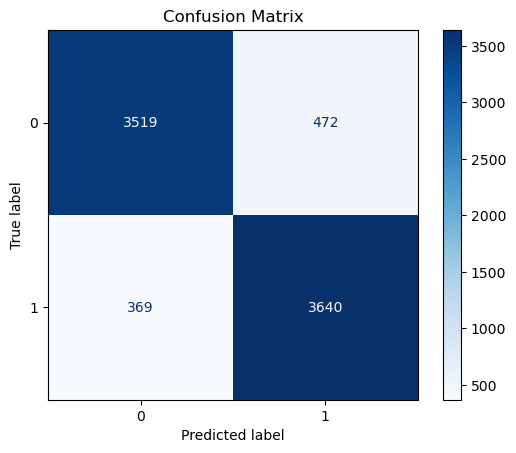

In [53]:
evaluation(model_lg_l, X_validation_l_tfid, y_validation)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3991
           1       0.89      0.90      0.89      4009

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000



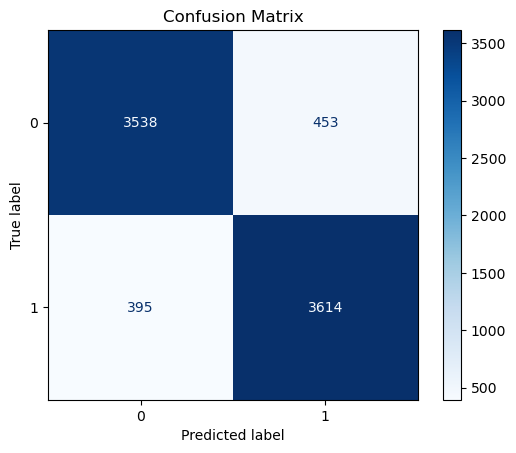

In [54]:
evaluation(model_svm, X_validation_l_tfid, y_validation)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      3991
           1       0.88      0.84      0.86      4009

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000



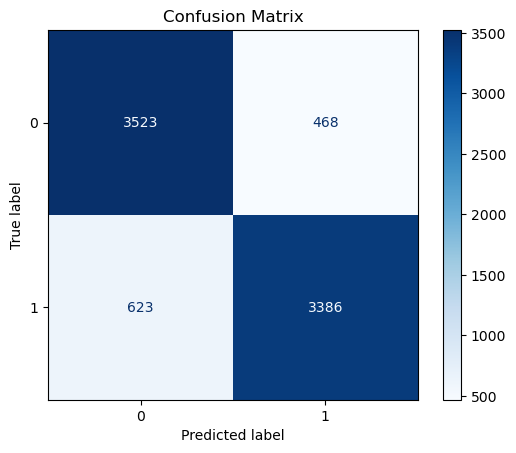

In [55]:
evaluation(model_mnb, X_validation_l_tfid, y_validation)

## **1.7 Hyperparameter Tuning**

- The best model is the Logistic Regression

In [56]:
solvers = ['liblinear']
penalty = ['l2']
c_values = [4.8, 4.9, 5, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 10]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model_lg_l, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy', verbose=3)

In [57]:
grid_result = grid_search.fit(X_validation_l_tfid, y_validation)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [58]:
print(grid_result.best_params_)

{'C': 4.8, 'penalty': 'l2', 'solver': 'liblinear'}


## **1.8 Predicting on Inference Data**

- Creating the model with the best pramameters from the tuning

In [59]:
lr = LogisticRegression(C=grid_result.best_params_['C'], penalty=grid_result.best_params_['penalty'], solver=grid_result.best_params_['solver'])
lr.fit(X_train_l_tfid, y_train)

LogisticRegression(C=4.8, solver='liblinear')

In [60]:
X_test = test_df['lemmatized_preprocessed_review']
y_test = test_df['sentiment'].values

- Transform text with the vectorizer

In [61]:
X_test_tfid = tfid_l.transform(X_test)

- Evaluation the model on the inference data set

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



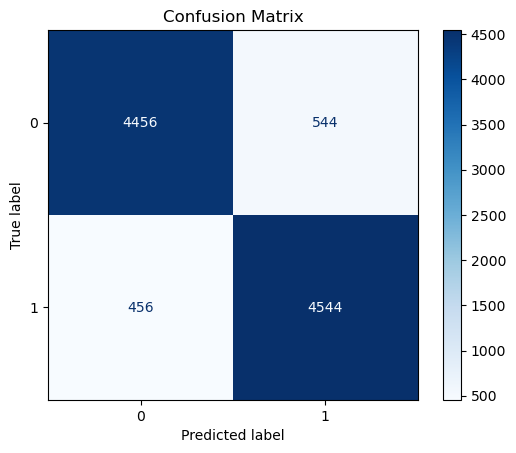

In [62]:
evaluation(lr, X_test_tfid, y_test)